In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install keras==1.2.2

In [3]:
pip install tensorflow==1.13.1

In [4]:
import h5py
import glob
import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.np_utils import to_categorical
from keras import backend as K
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
plt.ion()

Using TensorFlow backend.


In [5]:
import keras.regularizers
from keras.regularizers import l2, l1

nrows = 64
ncols = 64
wr = 0.00001
dp = 0.

real_in = Input(shape=(2, ), name = "real_input")

frame_in = Input(shape=(3, nrows, ncols), name = "img_input")

conv1 = Convolution2D(6, 3, 3, border_mode =  "same", W_regularizer = l1(wr), init = "lecun_uniform")
conv_l1 = conv1(frame_in)
Econv_l1 = ELU()(conv_l1)
pool_l1 = MaxPooling2D((2,2), border_mode =  "same")(Econv_l1)

conv2 = Convolution2D(8, 3, 3, border_mode =  "same", W_regularizer = l1(wr), init = "lecun_uniform")
conv_l2 = conv2(pool_l1)
Econv_l2 = ELU()(conv_l2)
pool_l2 = MaxPooling2D((2,2), border_mode =  "same")(Econv_l2)
drop_l2 = Dropout(dp)(pool_l2)

conv3 = Convolution2D(16, 3, 3, border_mode =  "same", W_regularizer = l1(wr), init = "lecun_uniform")
conv_l3 = conv3(drop_l2)
Econv_l3 = ELU()(conv_l3)
pool_l3 = MaxPooling2D((2,2), border_mode =  "same")(Econv_l3)
drop_l3 = Dropout(dp)(pool_l3)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
flat = Flatten()(drop_l3)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
M = merge([flat, real_in], mode = "concat", concat_axis = 1)

In [8]:
D1 = Dense(32, W_regularizer = l1(wr), init = "lecun_uniform")(M)
ED1 = ELU()(D1)
DED1 = Dropout(dp)(ED1)

S1 = Dense(64, W_regularizer = l1(wr), init = "lecun_uniform")(DED1)
ES1 = ELU()(S1)

In [9]:
Steer_out = Dense(1, activation = "linear", name = "steer_out", init = "lecun_uniform")(ES1)

In [10]:
model = Model(input = [real_in, frame_in], output = [Steer_out])
adam = Adam(lr = 0.001)

In [11]:
model.compile(loss = ['mse'], optimizer = adam, metrics = ['mse'])

In [12]:
all_data = np.load("/content/drive/MyDrive/CS274P/data/TrainingData.npz")

In [13]:
images = all_data['images']
speed = np.concatenate((all_data['speed'], all_data['accel']))
speed = speed.reshape((-1,2))
steer = all_data['steer']

In [14]:
nb_epoch = 4
mini_epoch = 2
num_steps = int(nb_epoch/mini_epoch)

for step in tqdm(range(0, num_steps)):
  
  h = model.fit([speed, images], {'steer_out' : steer}, batch_size = 32, 
                nb_epoch = mini_epoch, verbose = 1, validation_split = 0.1, shuffle = True)
  
  val_loss = h.history['val_loss'][-1]
  val_loss = round(val_loss, 8)
  
  model.save_weights('/content/drive/MyDrive/CS274P/data/FinalWeights.h5')

  0%|          | 0/2 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.
Train on 470190 samples, validate on 52244 samples
Epoch 1/2
470190/470190 [==============================] - 440s - loss: 0.0271 - mean_squared_error: 0.0207 - val_loss: 0.0049 - val_mean_squared_error: 0.0027
Epoch 2/2
470190/470190 [==============================] - 452s - loss: 0.0025 - mean_squared_error: 0.0021 - val_loss: 0.0026 - val_mean_squared_error: 0.0026


 50%|█████     | 1/2 [14:54<14:54, 894.64s/it]

Train on 470190 samples, validate on 52244 samples
Epoch 1/2
470190/470190 [==============================] - 460s - loss: 0.0022 - mean_squared_error: 0.0021 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/2
470190/470190 [==============================] - 477s - loss: 0.0022 - mean_squared_error: 0.0021 - val_loss: 0.0026 - val_mean_squared_error: 0.0026


100%|██████████| 2/2 [30:32<00:00, 916.19s/it]


In [15]:
model.load_weights('/content/drive/MyDrive/CS274P/data/YOLOweights.h5')

In [16]:
def get_point(s, start = 0, end = 63, height = 16):

  X = int(s*(end - start))

  if X < start: X = start

  if X > end: X = end

  return (X, height)

In [17]:
begin = 800
end = 1300
preds = model.predict([speed[begin:end], images[begin:end]])
steer_preds = preds.reshape([-1])

Done


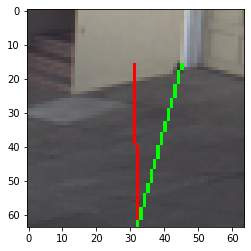

In [18]:
import matplotlib.animation as animation
from PIL import Image, ImageDraw
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

figure = plt.figure()
imageplot = plt.imshow(np.zeros((64, 64, 3), dtype = np.uint8))
val_idx = begin

def next_frame(i):

  im = Image.fromarray(np.array(images[val_idx+i].transpose(1,2,0), dtype = np.uint8))

  p = get_point(steer_preds[i])
  t = get_point(steer[i + val_idx])

  draw = ImageDraw.Draw(im)
  draw.line((32, 63, p, p), fill = (255, 0, 0, 128))
  draw.line((32, 63, t, t), fill = (0, 255, 0, 128))

  imageplot.set_array(im)

  return imageplot
animate = animation.FuncAnimation(figure, next_frame, frames=range(0, len(images[begin:end])), interval=25, blit=False)
print("Done")

In [19]:
animate

In [20]:
animate.save("/content/drive/MyDrive/CS274P/data/YOLO800.mp4")